In [1]:
import core.utils.configuration

Config = core.utils.configuration.initialize_config()

with Config:
    Config.Model.Name = 'Unet'
    Config.Model.Param = dict(encoder_name='resnet34')
    
    Config.Training.Settings.TrailNumber = 1
    Config.Training.Settings.Epochs = 30
    Config.Training.Settings.AmpScaleTrain = True
    
    Config.Training.Settings.Random.RootSeed = 100
    Config.Training.Settings.Random.cuDNN.Deterministic = True
    Config.Training.Settings.Random.cuDNN.Benchmark = True
    Config.Training.Dataset.CocoPath = 'D:/Datasets/coco2017'
    Config.Training.Dataset.GolferPath = r'D:\Datasets\Golf\IdealsLab2'
    Config.Training.Dataset.GolferCocoRatio = 2
    Config.Training.Dataset.DummyRatio = 0.25
    Config.Training.Dataset.NumWorkers = 0
    Config.Training.Dataset.PinMemory = False
    Config.Training.Dataset.PrefetchFactor = 2
    Config.Training.Dataset.Train.BatchSize = 8
    Config.Training.Dataset.Val.BatchSize = 16
    
    
    Config.Training.HybridLoss = {
        'multi_human_heatmap_param':        dict(shcedule=1,weight=0.5,delta=0.5,gamma=0.5),
        'leading_role_heatmap_param':       dict(shcedule=1,weight=0.5,delta=0.5,gamma=0.5),
        'golfclub_heatmap_param':           dict(shcedule=1,weight=0.5,delta=0.5,gamma=0.5),
        'leading_role_keypoints_param':     dict(shcedule=1),
        'leading_role_keypoints_cf_param':  dict(shcedule=1,delta=0.5,gamma=0.5,label_smoothing=0.5),
        'golfclub_keypoints_param':         dict(shcedule=1),
        'golfclub_keypoints_cf_param':      dict(shcedule=1,delta=0.5,gamma=0.5,label_smoothing=0.05),
        'leading_role_bbox_param':          dict(shcedule=1),
        'leading_role_bbox_cf_param':       dict(shcedule=1,delta=0.5,gamma=0.5,label_smoothing=0.05)
    }
    
    Config.Training.Optimizer.Name = 'Adam'
    Config.Training.Optimizer.Param = {'lr':0.001}
    Config.Training.LearningRateSchedule.Name = 'LinearWarmupExpReduce'
    Config.Training.LearningRateSchedule.Param = {'warmup_epochs':2}
    
    
    Config.Record.Frequence = 8
    Config.Record.RootPath = 'test_save_folder'
    Config.Record.SaveModelWeights = True
    Config.Record.Note = ''

In [2]:
%run train.py

loading annotations into memory...
Done (t=8.16s)
creating index...
index created!
loading annotations into memory...
Done (t=0.25s)
creating index...
index created!
================================================== train ==================================================
985 369 123


EPOCH: 0:   0%|          | 0/185 [00:12<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 72.00 MiB (GPU 0; 2.00 GiB total capacity; 1.06 GiB already allocated; 0 bytes free; 1.09 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

import core.dataset.training as training

reader = training.DataReader('train',f'D:/Datasets/coco2017',r'D:\Datasets\Golf\IdealsLab2')
reader = reader(2,0.25)

data_aug_processor = training.DataAugProcessor()
data_non_aug_processor = training.DataNonAugProcessor()

def vis_data(i,reader,dataprocessor):
    data = dataprocessor(reader[i])

    image = data['image']
    image = image.numpy().transpose([1,2,0])
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    image = np.clip(image,0,1)

    image_shape = image.shape[:2][::-1]

    plt.title('multi_people_heatmap flag:{}'.format(bool(data['multi_people_heatmap']['flag'])))
    plt.imshow(image)
    plt.imshow(cv2.resize(data['multi_people_heatmap']['heatmap'].max(axis=0),image_shape),alpha=0.5)
    plt.show()

    plt.title('leading_role_heatmap flag:{}'.format(bool(data['leading_role_heatmap']['flag'])))
    plt.imshow(image)
    plt.imshow(cv2.resize(data['leading_role_heatmap']['heatmap'].max(axis=0),image_shape),alpha=0.5)
    plt.show()

    plt.title('golfclub_heatmap flag:{}'.format(bool(data['golfclub_heatmap']['flag'])))
    plt.imshow(image)
    plt.imshow(cv2.resize(data['golfclub_heatmap']['heatmap'].max(axis=0),image_shape),alpha=0.5)
    plt.show()

    for i in range(17):
        if data['leading_role_keypoints']['cf'][i] == 1:
            xy = (data['leading_role_keypoints']['xy'][i] * np.array(image_shape)).astype(int)
            cv2.circle(image,xy,5,(1,0,0),2)
        else:
            assert (data['leading_role_keypoints']['xy'][i] == 0).all()

    for i in range(2):
        if data['golfclub_keypoints']['cf'][i] == 1:
            xy = (data['golfclub_keypoints']['xy'][i] * np.array(image_shape)).astype(int)
            cv2.circle(image,xy,5,(0,0,1),2)
        else:
            assert (data['golfclub_keypoints']['xy'][i] == 0).all()
            
    if data['leading_role_bbox']['cf'] == 1:
        xywh = (data['leading_role_bbox']['xywh'] * np.array([image_shape,image_shape]).flatten()).astype(int)
        cv2.rectangle(image,xywh[:2],xywh[:2]+xywh[2:],(1,0,0),2)
    else:
        assert (data['leading_role_bbox']['xywh'] == 0).all()
        
    plt.title('\n'.join([
        'leading_role_keypoints flag:{}'.format(bool(data['leading_role_keypoints']['flag'])),
        'leading_role_bbox flag:{}'.format(bool(data['leading_role_bbox']['flag'])),
        'golfclub_keypoints flag:{} {}'.format(bool(data['golfclub_keypoints']['flag']),data['golfclub_keypoints']['cf'].astype(bool))
        ]))
    plt.imshow(image)
    plt.show()

loading annotations into memory...
Done (t=8.68s)
creating index...
index created!
985 369 123


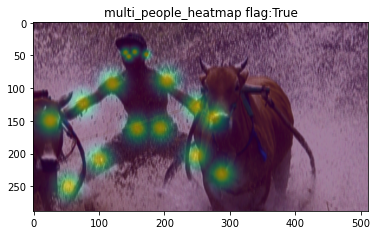

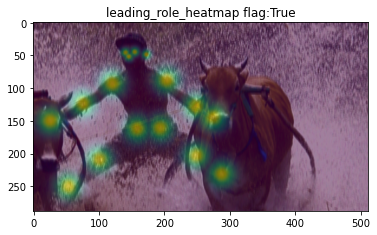

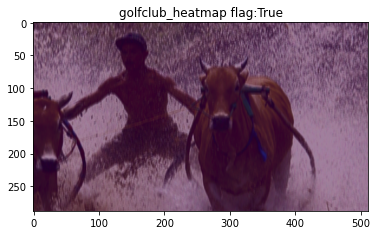

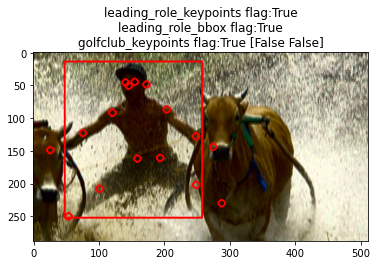

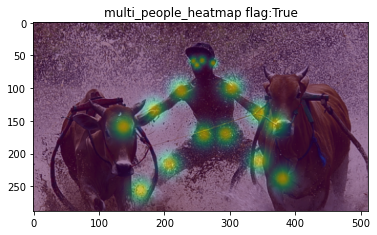

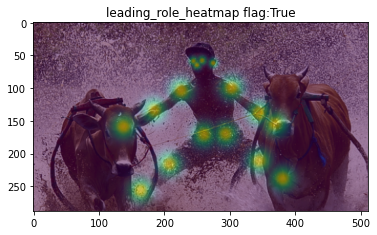

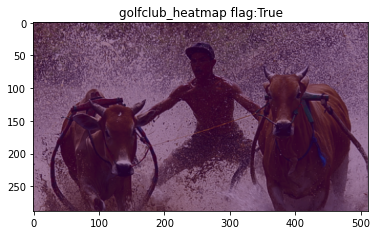

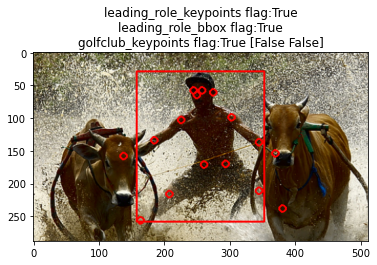

In [2]:
i = 1100
vis_data(i,reader,data_aug_processor)
vis_data(i,reader,data_non_aug_processor)